In [14]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.autograd import Variable

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [3]:
ds_test = ds_merged.isel(time=0, xt_ocean=slice(1500, 1600), yt_ocean=slice(1500, 1600))
ds_test

<xarray.Dataset> Size: 922kB
Dimensions:       (yt_ocean: 100, xt_ocean: 100)
Coordinates:
    time          object 8B 0181-01-01 12:00:00
  * xt_ocean      (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean      (yt_ocean) float64 800B 24.74 24.83 24.92 ... 33.22 33.3 33.38
    area_t        (yt_ocean, xt_ocean) float64 80kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 80kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 80kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 80kB dask.array<chunksize=(100, 100), meta=np.ndarray>
Data variables:
    slp           (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    wind          (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_ocean       (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_ocean       (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_relative    (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_relative    (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [4]:
urel = ds_test.u_relative
ds_urel = urel.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])
ds_urel

<xarray.DataArray 'u_relative' (yt_ocean: 100, xt_ocean: 100)> Size: 40kB
dask.array<getitem, shape=(100, 100), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    time      object 8B 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean  (yt_ocean) float64 800B 24.74 24.83 24.92 ... 33.22 33.3 33.38

Text(0.5, 1.0, 'Relative Zonal Velocity (u_rel) Power Spectra')

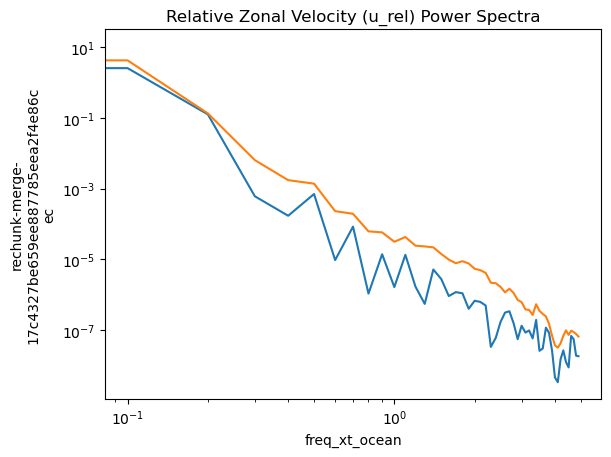

In [5]:
# Step 1: Prepare the Data
ps = xrft.power_spectrum(ds_urel.mean(dim='yt_ocean'), dim='xt_ocean', window=True)
ps1 = xrft.power_spectrum(ds_urel, dim='xt_ocean', window=True).mean(dim='yt_ocean')
ps.plot()
ps1.plot()
plt.yscale('log')
plt.xscale('log')
plt.title('Relative Zonal Velocity (u_rel) Power Spectra')

In [25]:
# Convert numpy arrays to PyTorch tensors
# Example data (inputs: X, targets: Y)

x_vals = np.log(ps.freq_xt_ocean.values)[52:-1] # remove nans
y_vals = np.log(ps.values)[52:-1] # remove nans

X_train = torch.from_numpy(x_vals).reshape(-1, 1).float()
Y_train = torch.from_numpy(y_vals).reshape(-1, 1).float()

In [26]:
# Step 2: Define the Model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)  # input and output features are 1

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel()

In [27]:
# Step 3: Define the Loss and Optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent

In [28]:
# Step 4: Training Loop
num_epochs = 1000
for epoch in range(num_epochs):

    inputs = Variable(X_train)
    labels = Variable(Y_train)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs, labels)
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 0, loss 239.67465209960938
epoch 1, loss 224.24533081054688
epoch 2, loss 209.85418701171875
epoch 3, loss 196.4307403564453
epoch 4, loss 183.90939331054688
epoch 5, loss 172.2289276123047
epoch 6, loss 161.3323516845703
epoch 7, loss 151.16650390625
epoch 8, loss 141.68185424804688
epoch 9, loss 132.83221435546875
epoch 10, loss 124.57456970214844
epoch 11, loss 116.86880493164062
epoch 12, loss 109.67752838134766
epoch 13, loss 102.96588134765625
epoch 14, loss 96.70140838623047
epoch 15, loss 90.85382843017578
epoch 16, loss 85.3949203491211
epoch 17, loss 80.29839324951172
epoch 18, loss 75.53971099853516
epoch 19, loss 71.09605407714844
epoch 20, loss 66.94609832763672
epoch 21, loss 63.07001495361328
epoch 22, loss 59.44929122924805
epoch 23, loss 56.06667709350586
epoch 24, loss 52.90609359741211
epoch 25, loss 49.95256423950195
epoch 26, loss 47.19211196899414
epoch 27, loss 44.61172866821289
epoch 28, loss 42.19926452636719
epoch 29, loss 39.94342041015625
epoch 30, los

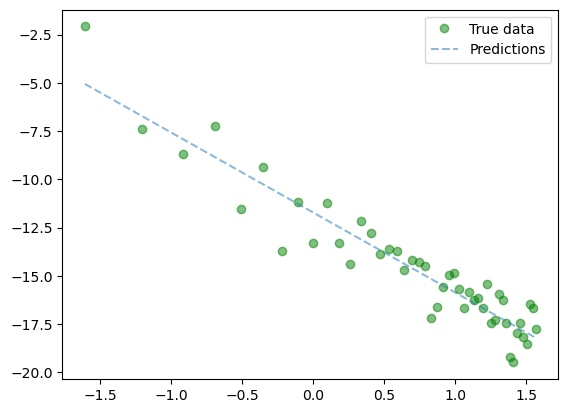

In [29]:
with torch.no_grad(): # we don't need gradients in the testing phase
    predicted = model(Variable(X_train)).data.numpy()

plt.clf()
plt.plot(X_train, Y_train, 'go', label='True data', alpha=0.5)
plt.plot(X_train, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()
